In [1]:
from __future__ import division

from time import time
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Dropout, Activation, Flatten, Reshape
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.utils import np_utils
from keras import backend as K
from keras import objectives
from keras.datasets import mnist, cifar100

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 650M (0000:01:00.0)


In [2]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 49  # Generator complexity
g_output_size = 100    # size of generated output vector

d_input_size = 100  # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'

minibatch_size = d_input_size

num_epochs = 50000
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [3]:
#parameter settings
batch_size = 128
nb_classes = 10
nb_epoch = 12

img_rows, img_cols = 28, 28
nb_filters = 32
nb_pool = 2
nb_conv = 3

In [4]:
def get_distribution_sampler(mu, sigma):
#     return lambda n : K.random_normal(mean=mu, std=sigma, shape=(1, n))
    return lambda m, n : np.random.normal(mu, sigma, size=(m, n)).astype("float32")

In [5]:
def get_generator_input_sampler():
#     return lambda m, n: K.random_uniform(shape=(m, n))
    return lambda m, n: np.random.rand(m, n).astype("float32")

In [6]:
#samplers for data distribution
gi_sampler = get_generator_input_sampler()
d_sampler = get_distribution_sampler(data_mean, data_stddev)

In [7]:
class Generator:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.model = Sequential()
        self.model.add(Dense(hidden_size, input_shape = (input_size,), activation = "elu"))
        self.model.add(Dense(hidden_size, activation = "elu"))
#         self.model.add(Dense(hidden_size, activation = "elu"))
#         self.model.add(Dense(output_size, activation = "linear"))
        self.model.add(Reshape((1, 7, 7)))
#         self.model.add(UpSampling2D(size=(2, 2)))
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=True,
                              activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
        self.model.add(UpSampling2D(size=(2, 2)))

        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=True,
                      activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
#         self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=True,
#               activation="elu", data_format="channels_first"))
#         self.model.add(Dropout(0.5))
        self.model.add(UpSampling2D(size=(2, 2)))
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=True,
          activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=True,
          activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
        self.model.add(Conv2D(filters=1, kernel_size=(3, 3), padding="same", use_bias=True,
                              activation="sigmoid", data_format="channels_first"))

In [8]:
class Discriminator:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.model = Sequential()
#         self.model.add(Dense(hidden_size, input_shape = (input_size,), activation = "elu"))
        self.model.add(Conv2D(filters=32, kernel_size=3, padding="same", use_bias=True,
                                     input_shape=(1, img_rows, img_cols), activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3),
                                     activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(filters=32, kernel_size=3, padding="same", use_bias=True,
                                     activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3),
                                     activation="elu", data_format="channels_first"))
        self.model.add(Dropout(0.5))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(hidden_size, activation = "elu"))
        self.model.add(Dense(output_size, activation = "sigmoid"))
    
    def compileModel(**kwargs):
        self.model.compile(**kwargs)

In [9]:
class GeneratorAndDiscriminator:
    
    def __init__(self, generator, discriminator):
        self.model = Sequential()
        self.model.add(generator)
        
        discriminator.trainable = False
        self.model.add(discriminator)
        

In [18]:
def print_progress(epoch, epochs, start_time):
    
    bar_length = 50
    
    progress_bar = "[" + "=" * int(bar_length * epoch / epochs) + \
    ">" + "-" * int(bar_length * (epochs - epoch) / epochs) + "]"
    
    time_taken = (time() - start_time)
    
    secs = np.ceil(time_taken * epochs / epoch - time_taken)
    hours = np.floor(secs / 3600)
    secs -= hours * 3600
    mins = np.floor(secs / 60)
    secs -= mins * 60
    
    sys.stdout.write("\r" + "Epoch {}/{} ".format(epoch, epochs) + progress_bar + 
                     " {}% ETA: {}h {}m {}s".format(int(epoch * 100 / epochs), int(hours), int(mins), int(secs)) + 
                     " " * 10)
    sys.stdout.flush()

In [11]:
#construct discriminator
D = Discriminator(d_input_size, d_hidden_size, d_output_size)

#compile D
D.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
#construct generator
G = Generator(g_input_size, g_hidden_size, g_output_size)

#compile G
G.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
##generator and discriminator
GD = GeneratorAndDiscriminator(G.model, D.model)

#compile GD
GD.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
##load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

##reshape data
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

num_patterns = len(x_train)

In [15]:
# %%time

'''
main loop
'''

n = 1

start_time = time()

for epoch in range(1, num_epochs+1):
    
    for d_step in range(d_steps):
        
        #train D on real data
#         d_real_data = d_sampler(1, d_input_size)
        d_real_data = np.expand_dims(x_train[np.random.randint(num_patterns)], axis=0)
#         d_real_data = x_train
        d_real_targets = np.ones(n)
        
        #train D on fake data
        d_gen_data = gi_sampler(n, g_input_size)
        d_fake_data = G.model.predict(d_gen_data)
        d_fake_targets = np.zeros(n)
        
        d_data = np.append(d_real_data, d_fake_data, axis=0)
        d_targets = np.append(d_real_targets, d_fake_targets)

        #fit discriminator
        D.model.trainable = True
        D.model.fit(d_data, d_targets, shuffle=True, epochs=3,
              batch_size=1, validation_split=0.0, verbose=0)
        
    for g_step in range(g_steps):
        
        #generate data from noise
        gen_input = gi_sampler(n, g_input_size)
        
        #target
        target = np.ones(n)
        
        #fit generator
        D.model.trainable = False
        GD.model.fit(gen_input, target, shuffle=True, epochs=3,
              batch_size=1, validation_split=0.0, verbose=0)
        
    print_progress(epoch, num_epochs, start_time)

print "\nDONE"

Epoch 50000/50000 [==================================================>] 100% ETA: 0.0h 0.0m 0.0s           
DONE


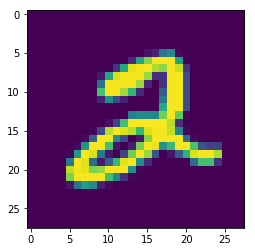

In [19]:
i = 5
plt.imshow(x_train[i, 0])
plt.show()

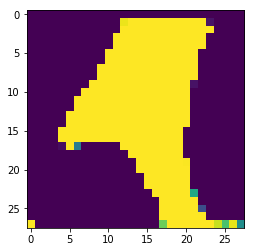

[[ 0.]]


In [20]:
gen_input = gi_sampler(1, g_input_size)
forgery = G.model.predict(gen_input)

# print np.mean(forgery)

i = 0

plt.imshow(forgery[i ,0])
plt.show()

print D.model.predict(forgery)

In [46]:
d_real_data = d_sampler(100, d_input_size)

In [47]:
d_real_data

array([[ 3.97750616,  5.25092888,  4.59791613, ...,  4.76979065,
         4.08094931,  2.61142635],
       [ 4.0486145 ,  4.50510311,  4.73263216, ...,  4.83788395,
         4.6385498 ,  3.18401814],
       [ 4.82702923,  6.47186995,  3.89000297, ...,  3.54565644,
         5.12652969,  6.09436893],
       ..., 
       [ 2.72764564,  4.03013802,  1.99318993, ...,  3.19162607,
         4.72337151,  2.75904036],
       [ 5.90803957,  1.71235585,  3.32587624, ...,  4.61864996,
         5.31416559,  5.39929628],
       [ 3.58024287,  3.90217638,  2.14244676, ...,  4.64943457,
         0.63970524,  1.97230172]], dtype=float32)